In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, Adamax, Adadelta

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Load Train, Test data

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape

(42000, 785)

### There are 42000 rows and 785 columns

## Checking for NA

In [6]:
train.isna().any().sum()

0

**There is no NA record in train data**

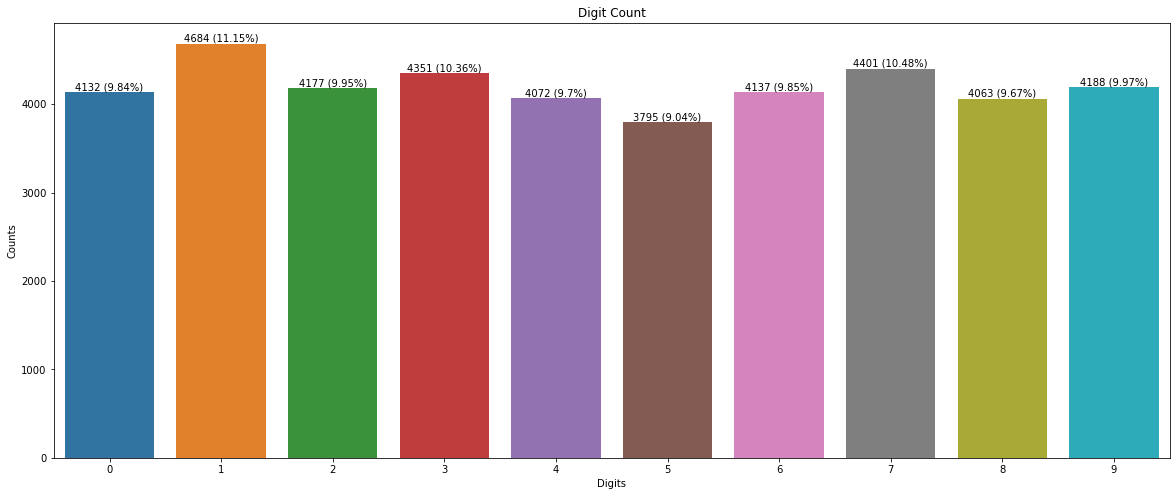

In [7]:
df_digit_counts =  train.label.value_counts().reset_index()

plt.figure(figsize=(20,8))
ax = sns.barplot(x='index', y='label', data=df_digit_counts)

for i in ax.patches:
    v1 = round((i.get_height()/len(train))*100, 2)
    ax.annotate(f'{int(i.get_height())} ({v1}%)', (i.get_x()+0.4, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Digit Count")
plt.ylabel("Counts")
plt.xlabel("Digits")
plt.show()

### Split train data in features and lables

In [8]:
train_X, train_y = train.drop(columns=['label']), train["label"]

> ### Convert train_X, train_y into numpy array

In [9]:
train_X = np.array(train_X)
train_y = np.array(train_y)

### Normalize Data

In [10]:
train_X = train_X / 255.0
test = test / 255.0

### Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [11]:
train_X = train_X.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [12]:
train_y = to_categorical(train_y, num_classes = len(np.unique(train["label"])))

### Split Training data into train and validation data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_X, 
                                                    train_y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify= train_y, 
                                                    shuffle=True)

In [14]:
epochs = 50
batch_size = 32

### Define Model

In [15]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10, activation = "softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [17]:
optimizer = Adamax()
model.compile(optimizer=optimizer, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)


In [20]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, 
                              batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_test,y_test), 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[lr_reduction, es], 
                              shuffle=True)

Train for 1050 steps, validate on 8400 samples
Epoch 1/50
1050/1050 [==============================] - 29s 27ms/step - loss: 0.6408 - accuracy: 0.7969 - val_loss: 0.0950 - val_accuracy: 0.9731
Epoch 2/50
1050/1050 [==============================] - 23s 22ms/step - loss: 0.1942 - accuracy: 0.9405 - val_loss: 0.0700 - val_accuracy: 0.9789
Epoch 3/50
1050/1050 [==============================] - 24s 23ms/step - loss: 0.1357 - accuracy: 0.9596 - val_loss: 0.0625 - val_accuracy: 0.9821
Epoch 4/50
1050/1050 [==============================] - 24s 22ms/step - loss: 0.0995 - accuracy: 0.9707 - val_loss: 0.0412 - val_accuracy: 0.9890
Epoch 5/50
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0832 - accuracy: 0.9751 - val_loss: 0.0332 - val_accuracy: 0.9904
Epoch 6/50
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0668 - accuracy: 0.9808 - val_loss: 0.0339 - val_accuracy: 0.9912
Epoch 7/50
1050/1050 [==============================] - 24s 23ms/step - loss:

### Evaluate Model

In [21]:
model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

8400/8400 [==============================] - 1s 151us/sample - loss: 0.0209 - accuracy: 0.9945


([0.006979564501489221, 0.998125], [0.020889560016373817, 0.9945238])

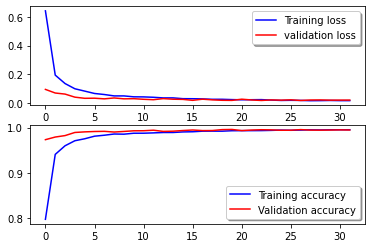

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

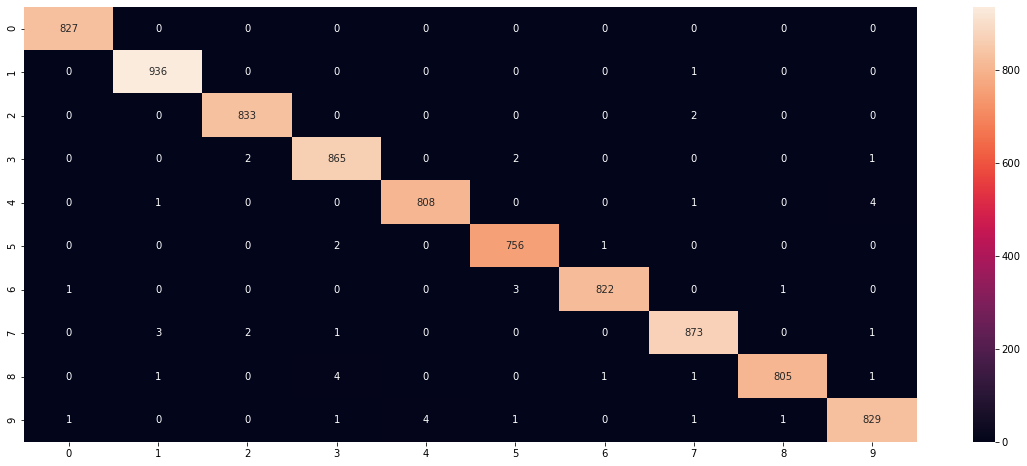




              precision    recall  f1-score   support

           0       1.00      1.00      1.00       827
           1       0.99      1.00      1.00       937
           2       1.00      1.00      1.00       835
           3       0.99      0.99      0.99       870
           4       1.00      0.99      0.99       814
           5       0.99      1.00      0.99       759
           6       1.00      0.99      1.00       827
           7       0.99      0.99      0.99       880
           8       1.00      0.99      0.99       813
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



In [23]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(20,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

print("\n\n")
print(classification_report(ytest, ypred))

## Submission

In [24]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("digit_reconizer_submission_rsb_updated.csv",index=False)